<a href="https://colab.research.google.com/github/ntienvu/KnownOptimum_BO/blob/master/run_all_benchmark_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/ntienvu/KnownOptimum_BO

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ntienvu/KnownOptimum_BO to /tmp/pip-req-build-tuf8qqvy
  Running command git clone --filter=blob:none --quiet https://github.com/ntienvu/KnownOptimum_BO /tmp/pip-req-build-tuf8qqvy
  Resolved https://github.com/ntienvu/KnownOptimum_BO to commit f2175f4a23b4f6eeda1e77efb504082cc17c7d4b
  Preparing metadata (setup.py) ... done


# Demo on benchmark functions

In [2]:
import matplotlib.pyplot as plt
from bayes_opt import BayesOpt_KnownOptimumValue,BayesOpt
import numpy as np
from bayes_opt import vis_ERM,functions,utilities
import warnings

warnings.filterwarnings("ignore")


# Select a function to run the experiment

In [3]:
#myfunction=functions.branin()
myfunction=functions.hartman_3d()
#myfunction=functions.ackley(input_dim=5)
#myfunction=functions.gSobol(a=np.array([1,1,1,1,1]))
#myfunction=functions.hartman_6d()

print("func:",myfunction.name)


func: hartman_3d


# Select a list of acquisition functions to compare


In [4]:
acq_type_list=[]

temp={}
temp['name']='erm' # expected regret minimization
temp['IsTGP']=1 # recommended to use tgp for ERM
acq_type_list.append(temp)

temp={}
temp['name']='cbm' # confidence bound minimization
temp['IsTGP']=1 # recommended to use tgp for CBM
acq_type_list.append(temp)

temp={}
temp['name']='ucb' # vanilla UCB
temp['IsTGP']=0 # we can try 'tgp' by setting it =1
#acq_type_list.append(temp)

temp={}
temp['name']='ei' # vanilla EI
temp['IsTGP']=0 # we can try 'tgp' by setting it =1
acq_type_list.append(temp)

temp={}
temp['name']='random' # random
temp['IsTGP']=0 # we can try 'tgp' by setting it =1
acq_type_list.append(temp)

# Run the experiments across different acquisition functions

---



==================acquisition type {'name': 'erm', 'IsTGP': 1}
ii=0 Best Found Value=-3.777
ii=1 Best Found Value=-3.835
ii=2 Best Found Value=-3.847
ii=3 Best Found Value=-3.828
ii=4 Best Found Value=-3.795
ii=5 Best Found Value=-3.854
ii=6 Best Found Value=-3.829
ii=7 Best Found Value=-3.807
ii=8 Best Found Value=-3.707
ii=9 Best Found Value=-3.858
==================acquisition type {'name': 'cbm', 'IsTGP': 1}
ii=0 Best Found Value=-3.630
ii=1 Best Found Value=-3.803
ii=2 Best Found Value=-3.812
ii=3 Best Found Value=-3.744
ii=4 Best Found Value=-3.647
ii=5 Best Found Value=-3.796
ii=6 Best Found Value=-3.696
ii=7 Best Found Value=-3.820
ii=8 Best Found Value=-3.812
ii=9 Best Found Value=-3.859
==================acquisition type {'name': 'ei', 'IsTGP': 0}
ii=0 Best Found Value=-3.579
ii=1 Best Found Value=-3.616
ii=2 Best Found Value=-3.795
ii=3 Best Found Value=-3.832
ii=4 Best Found Value=-3.825
ii=5 Best Found Value=-3.801
ii=6 Best Found Value=-3.851
ii=7 Best Found Value=-3.825


Text(0.5, 1.0, 'hartman_3d D=3')

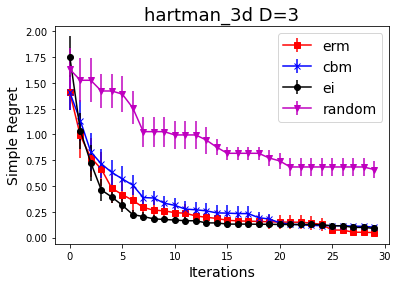

In [5]:
fig=plt.figure()

color_list=['r','b','k','m','c','g']
marker_list=['s','x','o','v','^','>']

for idx, acq_type in enumerate(acq_type_list):

    print("==================acquisition type",acq_type)
    
    IsTGP=acq_type['IsTGP']
    acq_name=acq_type['name']
    
    nRepeat=10
    
    ybest=[0]*nRepeat
    ElapseTime=[0]*nRepeat
    OptTime=[0]*nRepeat
    marker=[0]*nRepeat
    bo=[0]*nRepeat
   
    for ii in range(nRepeat): # run over multiple repetitions
        
        if 'kov' in acq_name or acq_name == 'erm' or acq_name == 'cbm':
            bo[ii]=BayesOpt_KnownOptimumValue(myfunction.func,myfunction.bounds,\
                                myfunction.fstar,acq_name,IsTGP,verbose=0)
        else:
            bo[ii]=BayesOpt(myfunction.func,myfunction.bounds,acq_name,verbose=0)
  
        if acq_name =='random': # we generate random points without running BO
            ybest[ii],ElapseTime[ii]=utilities.run_experiment(bo[ii],
                 n_init=13*myfunction.input_dim,NN=0,runid=ii)   
        else:
            ybest[ii],ElapseTime[ii]=utilities.run_experiment(bo[ii],
                                        n_init=3*myfunction.input_dim,\
                                        NN=10*myfunction.input_dim,runid=ii)   
                                       
        OptTime[ii]=bo[ii].time_opt # record the computational time
        print("ii={} Best Found Value={:.3f}".format(ii,myfunction.ismax*np.max(ybest[ii])))                                              

    # record the result and save to pickle files================================
    # Score={}
    # Score["ybest"]=ybest
    # Score["ElapseTime"]=ElapseTime
    # Score["OptTime"]=OptTime
    # utilities.print_result_sequential(bo,myfunction,Score,acq_type) 
    
    # plot the result ==========================================================
    y_best_sofar=[0]*len(bo)
    for uu,mybo in enumerate(bo):
        y_best_sofar[uu]=[ (myfunction.fstar - np.max(mybo.Y_ori[:ii+1]) ) for ii in range(len(mybo.Y_ori))]
        y_best_sofar[uu]=y_best_sofar[uu][3*myfunction.input_dim:] # remove the random phase for plotting purpose
        
    y_best_sofar=np.asarray(y_best_sofar)
    xaxis=range(y_best_sofar.shape[1])
    plt.errorbar(xaxis,np.mean(y_best_sofar,axis=0), np.std(y_best_sofar,axis=0)/np.sqrt(nRepeat),
                 label=acq_type['name'],color=color_list[idx],marker=marker_list[idx])
    
plt.ylabel("Simple Regret",fontsize=14)
plt.xlabel("Iterations",fontsize=14)
plt.legend(prop={'size': 14})
strTitle="{:s} D={:d}".format(myfunction.name,myfunction.input_dim)
plt.title(strTitle,fontsize=18)
